In [3]:
!pip install nltk
!pip install pandas



import csv
import pandas as pd
import os

import re
import nltk
import string
nltk.download('punkt')

resourceFolder = 'resources'
outputFolder = 'output'


def getResourceFolderPath(fileName) : 
    return  os.path.join(os.path.join(os.getcwd(), resourceFolder), fileName)
def getOutputFolderPath(folder, fileName) : 
    return  os.path.join(os.path.join(os.path.join(os.getcwd(), outputFolder), folder), fileName)

def loadCSVData(path):
    return pd.read_csv(getResourceFolderPath(path), encoding="utf-8")

def loadTxtData(path, sep, columns, encoding = "utf-8"):
    result = pd.read_csv(getResourceFolderPath(path), sep, header=None, engine='python', encoding= encoding)
    result.columns = columns
    return result

def getFullPath(folder, file):
    if not os.path.exists(outputFolder):
        os.mkdir(outputFolder)
    folder = os.path.join(outputFolder, folder)
    if not os.path.exists(folder):
        os.mkdir(folder)
    return os.path.join(folder, file)    

def writeCSV(folder,file, list):
    with open(getFullPath(folder, file), "w", newline="", encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerows(list)

def writeDFCSV(folder,file, dataframe):
    dataframe.to_csv(getFullPath(folder, file))



[nltk_data] Downloading package punkt to /home/nbuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Answer (a)

1. removing any remaining irrelevant content such as non-alphanumeric characters and possible extraneous html tags, 
2. tokenizing the text by separating into individual words 
3. converting the case of the ‘Singlish’ tokens to obtain unique words. 
4. separate the data into two sets – one for Sinhala and the other for ‘Singlish’ entries and print the percentage of entries in the two sets

In [17]:

#clear the given text using regex 
def cleanText(text):
    stripped = text.strip()
    PATTERN = r'[,|.|?|$|#|!|&|*|%|@|(|)|~|^0-9]'
    result = re.sub(PATTERN, r'', stripped)
    return result.lower().replace('"', '') 

# create a list of tokens for for the given text 
def tokenize(text):
    sentences = nltk.sent_tokenize(text)
    wordTokens = [nltk.word_tokenize(sentence) for sentence in sentences]
    return wordTokens

# clear the text after tokenization
def cleanAftertokenization(tokens):
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    filteredTokens =  filter(None, [pattern.sub('', token) for token in tokens])
    return [token for token in tokens if pattern.sub('', token) != None]


# check if given string is english 
# we use encoding methods to identify if it passes anexception we it will be a sinhala text 
def isWordEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

# retrun the word if it matches the passed lanaguage else none 
def checkGetWordByLanguage(word,isEnglish):
    if (isEnglish and isWordEnglish(word) or ((not isEnglish) and (not isWordEnglish(word)))):
        return word
    else :
        return None

# create a list for the given language
def createLanguageSeparatedList(list,isEnglish):
    # select only sinhala words
    return [text for text in list if checkGetWordByLanguage(text, isEnglish) != None]

# results for part 1 
def part1result(outputResult = False):
    # load the data 
    data = loadCSVData('Sinhala_Singlish_Hate_Speech.csv')
    #clear 
    data["CleanedPhrase"] = data["Phrase"].apply(cleanText)
    # tokenize
    data["TokenFullList"] = data["CleanedPhrase"].apply(tokenize)
    # convert to a single list
    data["SingleList"] = [fullsentence for line in data["TokenFullList"] for fullsentence in line]
    #final tokens 
    data["Tokens"] = data["SingleList"].apply(cleanAftertokenization)
    # sinhala only token list 
    data["SinhalaTokens"] = [createLanguageSeparatedList(tokens, False) for tokens in data["Tokens"] ]
    # english/singli
    data["EnglishTokens"] = [createLanguageSeparatedList(tokens, True) for tokens in data["Tokens"] ]
    data["TokenCount"] = data.apply(lambda row: len(row.Tokens), axis=1)
    data["SinhalaTokenCount"] = data.apply(lambda row: len(row.SinhalaTokens), axis=1)
    data["EnglishTokenCount"] = data.apply(lambda row: len(row.EnglishTokens), axis=1)
    # calculate the percentages
    data["SinhalaTokenPercentage"] = data.apply(lambda row: (  row.SinhalaTokenCount / row.TokenCount) * 100, axis=1)
    data["EnglishTokenPercentage"] = data.apply(lambda row: (  row.EnglishTokenCount / row.TokenCount) * 100, axis=1)
    
    # need to do  spelling
    
    # print as csv
    if(outputResult):
        writeDFCSV("part1", "result.csv", data)
        writeCSV("part1", "sinhala-word-list.csv", data["SinhalaTokens"].tolist())
        writeCSV("part1", "english-word-list.csv", data["EnglishTokens"].tolist())
    
    datashow = data[['PhraseNo', 'SinhalaTokenPercentage', 'EnglishTokenPercentage', 'IsHateSpeech']].copy()

    print(datashow)
    
    return data

data = part1result(False)


      PhraseNo  SinhalaTokenPercentage  EnglishTokenPercentage IsHateSpeech
0            1              100.000000                0.000000          YES
1            2              100.000000                0.000000          YES
2            3              100.000000                0.000000           NO
3            4              100.000000                0.000000          YES
4            5              100.000000                0.000000          YES
5            6              100.000000                0.000000          YES
6            7              100.000000                0.000000          YES
7            8                0.000000              100.000000          YES
8            9              100.000000                0.000000          YES
9           10              100.000000                0.000000          YES
10          11              100.000000                0.000000          YES
11          12                0.000000              100.000000          YES
12          

- We have cleaned the data set and then tokanized.
- Separated to two columns in the data frame for futher use 

### Answer (b)

1. remove the so called stopwords 
2. to stem the rest of the words. Print the number of total tokens
3. the number of unique tokens before this step and after each of the above two steps for the Sinhala dataset.

In [18]:
# removes stop words in the list using the passed stop word list 
def removeStopwords(stopwords, tokens):
    return [token for token in tokens if token not in stopwords]

# updates stem words according to passed stem list and returns the list of tokens 
def updateToStem(stemWordList, tokens):
    result = []
    for token in tokens:
        row = stemWordList[stemWordList["word"] == token]
        if not row.empty :
            result.append(row["stem"].values.tolist()[0])
        else :
            result.append(token)
    return result

def part2result(data, outputResult = False):
    # load stop words 
    stopwords = loadTxtData('StopWords.txt', '\t', ['stopword', 'number'], "utf16")
    # load stem words
    stemwords = loadTxtData('stem_dictionary.txt', '\t', ['word', 'stem'])
    # create list after stop word removal
    data["AfterStopWord"] = [removeStopwords(stopwords["stopword"].values.tolist(), tokenList) for tokenList in data["Tokens"]]
    # create list after stemming 
    data["FullTokens"] = [updateToStem(stemwords, tokenList) for tokenList in data["AfterStopWord"]]
    # sinhala only token list 
    data["FullSinhalaTokens"] = [createLanguageSeparatedList(tokens, False) for tokens in data["FullTokens"] ]
    # english/singlish token list 
    data["FullEnglishTokens"] = [createLanguageSeparatedList(tokens, True) for tokens in data["FullTokens"] ]
    
    
    data["FinalTokenCount"] = data.apply(lambda row: len(row.FullTokens), axis=1)
    data["FinalSinhalaTokenCount"] = data.apply(lambda row: len(row.FullSinhalaTokens), axis=1)
    data["FinalEnglishTokenCount"] = data.apply(lambda row: len(row.FullEnglishTokens), axis=1)
    
    
    # clean up the data set 
    data = data[['PhraseNo', 'TokenCount', 'SinhalaTokenCount', 'EnglishTokenCount', 'FinalTokenCount', 'FinalSinhalaTokenCount', 'FinalEnglishTokenCount' ,'FullTokens', 'FullSinhalaTokens', 'FullEnglishTokens', 'IsHateSpeech']].copy()
    
    # print as csv
    if(outputResult):
        writeDFCSV("part2", "result.csv", data)
        
    
    print("=============== Total Tokens ===============")
    print("Total tokens {}".format(data["TokenCount"].sum()))
    print("=============== Total Tokens ===============")
    print()

    print("=============== Maximum Sentence Length ===============")
    print("Total tokens {}".format(data["TokenCount"].max()))
    print("=============== Maximum Sentence Length ===============")
    print()

    print("=============== Minimum Sentence Length ===============")
    print("Total tokens {}".format(data["TokenCount"].min()))
    print("=============== Minimum Sentence Length ===============")
    print()


    datashow = data[['PhraseNo', 'TokenCount', 'FinalTokenCount', 'SinhalaTokenCount' , 'FinalSinhalaTokenCount', 'EnglishTokenCount', 'FinalEnglishTokenCount']].copy()

    print(datashow)
    
    
    return data

data = part2result(data, False)


=============== Total Tokens ===============
Total tokens 43041
=============== Total Tokens ===============

=============== Maximum Sentence Length ===============
Total tokens 133
=============== Maximum Sentence Length ===============

=============== Minimum Sentence Length ===============
Total tokens 1
=============== Minimum Sentence Length ===============

      PhraseNo  TokenCount  FinalTokenCount  SinhalaTokenCount  \
0            1          36               32                 36   
1            2          17               15                 17   
2            3           4                3                  4   
3            4           9                9                  9   
4            5          25               21                 25   
5            6          36               31                 36   
6            7          21               18                 21   
7            8          16               16                  0   
8            9          20            

Bar Chart to  demostrate 

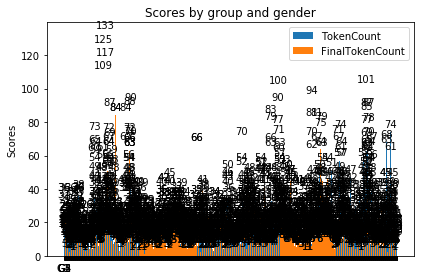

In [21]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(data["PhraseNo"].values.tolist()))  # the label locations
width = 0.70  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, data["TokenCount"].values.tolist(), width, label='TokenCount')
rects2 = ax.bar(x + width/2, data["FinalTokenCount"].values.tolist(), width, label='FinalTokenCount')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


### Answer (c)

1. Create bag-of-words representations of the Sinhala and Singlish datasets separately.
2. Fit logistic regression models2 to the data in order to be able to predict whether a post constitutes hate speech or not using 20% of the data for testing. 
3. What is the accuracy, precision, recall and f1 measure of this model for the two datasets? 
4. Print also the confusion matrix in order to see what kind of errors it is making, and comment on it. 
5. Also check the most important words the model uses to discriminate between hate words and others for each of the two datasets3.

In [22]:
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import gensim
from sklearn import metrics
import numpy as np
from sklearn.linear_model import SGDClassifier
import re
    
warnings.filterwarnings('ignore')
    
#first we divide to train and test data sets 

def prepare_datasets(corpus, labels, test_data_proportion=0.2):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels, 
                                                        test_size=test_data_proportion, random_state=42)
    return train_X, test_X, train_Y, test_Y


# First we do feature extraction using Courter Vectorizer

def bow_extractor(corpus, ngram_range=(1,1)):
    vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features


def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        2))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        2))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        2))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        2))
                        

def train_predict_evaluate_model(classifier, 
                                 train_features, train_labels, 
                                 test_features, test_labels, text):
    # build model    
    classifier.fit(train_features, train_labels)
    # predict using model
    predictions = classifier.predict(test_features) 
    # evaluate model prediction performance 
    print("------------------------Model metrice for {}------------------------".format(text))
    get_metrics(true_labels=test_labels, 
                predicted_labels=predictions)
    return predictions 

def getConfussionMatrix(test_labels, prediction, description):
    cm = metrics.confusion_matrix(test_labels, prediction)
    pd.DataFrame(cm, index=range(0,2), columns=range(0,2))
    
    print("------------------------Confussion metrice for {}------------------------".format(description))
    
    print("                     Prediction    ")
    print("                 P     |    N   ")
    print("              ---------|---------")
    print("               P {0}       {1}   ".format(cm[0][0], cm[0][1]))
    print("    Actual   ----------|---------")
    print("               N {0}       {1}   ".format(cm[1][0], cm[1][1]))    
    print("                       | ") 
    
    return cm

def getCoeeffienct(classiffier, vectorizer, description):
    print("------------------------Most important words the model for {}  ------------------------".format(description))
    #get the indexes of the maximum 20 coef_ values
    max_coef_indexes = classiffier.coef_[0].argsort()[::-1][:20]
    
    for index in max_coef_indexes:
        print("   " + vectorizer.get_feature_names()[index])

    # Checking the misclassified documents for error analysis
def checkForMisclassified(test_corpus, test_labels, predictor):
    num = 0
    for document, label, predicted_label in zip(test_corpus, test_labels, predictor):        
        if label != predicted_label:
            print('Actual Label:', label)
            print('Predicted Label:', predicted_label)
            print('Document:-')
            print(re.sub('\n', ' ', document))
            print()
            num += 1
            if num == 4:
                break
                
    
                
def predict(dataframe, corpusText, labelText, splitPercentage, classiffier, description):
    # differentiate the data for train and test sets 
    train_corpus, test_corpus, train_labels, test_labels = prepare_datasets(dataframe[corpusText],
                                                                                dataframe[labelText],
                                                                                test_data_proportion=splitPercentage)
    # bag of words transformation 
    bow_vectorizer, bow_train_features = bow_extractor(train_corpus)  
    bow_test_features = bow_vectorizer.transform(test_corpus)
    
    bow_predictions = train_predict_evaluate_model(classifier=classiffier,
                                                       train_features=bow_train_features,
                                                       train_labels=train_labels,
                                                       test_features=bow_test_features,
                                                       test_labels=test_labels,
                                                        text = description)
    
    # Confusion matrix for the CV based SVM
    cm = getConfussionMatrix(test_labels, bow_predictions, description)
    
    
    getCoeeffienct(classiffier, bow_vectorizer, description)
    
    #print("------------------------Mis classified records sample {}------------------------".format(description))
    #checkForMisclassified(test_corpus, test_labels, bow_predictions)
    

def part3Result(data):
    
    # create separate dataframes with only sinhala or singlsih content data 
    data["SinhalaFullTokenCount"] = data.apply(lambda row: len(row.FullSinhalaTokens), axis=1)
    data["EnglishFullTokenCount"] = data.apply(lambda row: len(row.FullEnglishTokens), axis=1)
    sinhala_corpus = data[data.SinhalaFullTokenCount > 0]
    singlish_corpus = data[data.EnglishFullTokenCount > 0]
    sinhala_corpus["FullText"] = data.apply(lambda row: ' '.join(row.FullSinhalaTokens), axis=1)
    singlish_corpus["FullText"] = data.apply(lambda row: ' '.join(row.FullEnglishTokens), axis=1)
    
    #predict for sinhala only data set 
    svm = SGDClassifier(loss='hinge', n_iter=100)
    predict(sinhala_corpus, "FullText", "IsHateSpeech", 0.2, svm, "Sinhala only data set")
    
    #predict for singlish only data set 
    svm = SGDClassifier(loss='hinge', n_iter=100)
    predict(singlish_corpus, "FullText", "IsHateSpeech", 0.2, svm, "Singlish only data set")
    
part3Result(data)

------------------------Model metrice for Sinhala only data set------------------------
Accuracy: 0.65
Precision: 0.65
Recall: 0.65
F1 Score: 0.64
------------------------Confussion metrice for Sinhala only data set------------------------
                     Prediction    
                 P     |    N   
              ---------|---------
               P 146       47   
    Actual   ----------|---------
               N 80       89   
                       | 
------------------------Most important words the model for Sinhala only data set  ------------------------
   ජම
   මරල
   ඉග
   ඇම
   පකය
   ආන
   රව
   පලයව
   සමනල
   කවලවම
   ජනප
   බණට
   බළ
   ඇර
   කහන
   රඟප
   එර
   හශ
   ඇගට
   දඬ
------------------------Model metrice for Singlish only data set------------------------
Accuracy: 0.65
Precision: 0.66
Recall: 0.65
F1 Score: 0.65
------------------------Confussion metrice for Singlish only data set------------------------
                     Prediction    
             

- We create separate data frames 
- Get full text for those data frames 
- Pass it for the predecion  

### Answer (d)

1. Repeat step (c) treating the full data set (Sinhala and ‘Singlish’) as one and compare the results with (c). 
2. Based on your results, decide whether to process these two data sets together or separately for the following tasks.


In [23]:
def partDResult(data):
    
    # create separate dataframes with only sinhala or singlsih content data 
    data["FullText"] = data.apply(lambda row: ' '.join(row.FullTokens), axis=1)
    
    #predict for sinhala only data set 
    svm = SGDClassifier(loss='hinge', n_iter=100)
    predict(data, "FullText", "IsHateSpeech", 0.2, svm, "Full data set")
    
partDResult(data)

------------------------Model metrice for Full data set------------------------
Accuracy: 0.67
Precision: 0.67
Recall: 0.67
F1 Score: 0.66
------------------------Confussion metrice for Full data set------------------------
                     Prediction    
                 P     |    N   
              ---------|---------
               P 215       57   
    Actual   ----------|---------
               N 109       119   
                       | 
------------------------Most important words the model for Full data set  ------------------------
   ජම
   අගම
   මරල
   ලකණ
   පකය
   නමට
   ලකන
   මමද
   පලයව
   රව
   ආන
   මචන
   මස
   කහන
   කනව
   වද
   රවන
   එතන
   තරල
   ඵළ


 - We run the same way for full text 
 
 ### Part D

2. Based on your results, decide whether to process these two data sets together or separately for the following tasks.

*Based on the above results combining and running it gives better results compared to separated corpuses*



### Answer (e)

1. Implement a logistic regression model to the dataset after transforming it to their tf-idf values4. 
2. In order to test the stability of the predictive power of this model, this time compute the cross-validation scores for accuracy, precision, recall and f1 score for it. 
3. Also check the most important words the model uses to discriminate between relevant and irrelevant words as before.

In [24]:
# Insert #represent the tokens in a count vector
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from functools import partial
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer


def tfidf_extractor(corpus, ngram_range=(1,1)):
    
    vectorizer = TfidfVectorizer(min_df=1, 
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features


#printing the measurements for cross validation for 5 flods
def print_cross_validation_model_measurements(model, data_test, label_test):       
    
    #https://stackoverflow.com/a/39197222
    #https://github.com/scikit-learn/scikit-learn/issues/3570
    precision_scorer = make_scorer(precision_score, pos_label='YES')
    recall_scorer = make_scorer(recall_score, pos_label='YES')
    f1_scorer = make_scorer(f1_score, pos_label='YES')
    
    acuuracy = cross_val_score(model, data_test, label_test, cv=5)
    precision = cross_val_score(model, data_test, label_test, cv=5, scoring=precision_scorer)
    recall = cross_val_score(model, data_test, label_test, cv=5, scoring=recall_scorer)
    f1_score_result = cross_val_score(model, data_test, label_test, cv=5, scoring=f1_scorer)

    print("Accuracy of cross validated logistic regression : %0.2f (+/- %0.2f)" % (acuuracy.mean(), acuuracy.std() * 2))
    print("Precision of cross validated logistic regression : %0.2f (+/- %0.2f)" % (precision.mean(), precision.std() * 2))
    print("Recall of cross validated logistic regression : %0.2f (+/- %0.2f)" % (recall.mean(), recall.std() * 2))
    print("F1-Score of cross validated logistic regression : %0.2f (+/- %0.2f)" % (f1_score_result.mean(), f1_score_result.std() * 2))
    

def predictLogisticalRegression(dataframe, corpusText, labelText, splitPercentage, classifier, description, ngrams, runCoeffecient = True):
    # differentiate the data for train and test sets 
    train_corpus, test_corpus, train_labels, test_labels = prepare_datasets(dataframe[corpusText],
                                                                                dataframe[labelText],
                                                                                test_data_proportion=splitPercentage)
    
    tfidf_vectorizer, tfidf_train_features = tfidf_extractor(train_corpus, ngrams)  
    tfidf_test_features = tfidf_vectorizer.transform(test_corpus)
    
    
    
    # bag of words transformation 
    tfidf_vectorizer, tfidf_feature = tfidf_extractor(data[corpusText])
    
    tfidf_predictions = train_predict_evaluate_model(classifier=classifier,
                                                       train_features=tfidf_train_features,
                                                       train_labels=train_labels,
                                                       test_features=tfidf_test_features,
                                                       test_labels=test_labels,
                                                        text = description)
    
    print_cross_validation_model_measurements(classifier, tfidf_feature, data[labelText])
    
    cm = getConfussionMatrix(test_labels, tfidf_predictions, description) 
    
    if runCoeffecient :
        getCoeeffienct(classifier, tfidf_vectorizer, description)
    
    
tfidf_model = LogisticRegression(random_state=0, solver='lbfgs', max_iter = 1000)

predictLogisticalRegression(data, "FullText", "IsHateSpeech", 0.2, tfidf_model,  "Full data set", (1,1))


# pipeline below

------------------------Model metrice for Full data set------------------------
Accuracy: 0.67
Precision: 0.68
Recall: 0.67
F1 Score: 0.65
Accuracy of cross validated logistic regression : 0.65 (+/- 0.10)
Precision of cross validated logistic regression : 0.68 (+/- 0.16)
Recall of cross validated logistic regression : 0.39 (+/- 0.20)
F1-Score of cross validated logistic regression : 0.49 (+/- 0.21)
------------------------Confussion metrice for Full data set------------------------
                     Prediction    
                 P     |    N   
              ---------|---------
               P 229       43   
    Actual   ----------|---------
               N 123       105   
                       | 
------------------------Most important words the model for Full data set  ------------------------
   උපක
   ජනයක
   උපද
   එවනව
   කවරණය
   උඹලග
   wunu
   wedagthm
   thunema
   එකල
   lassanaimn
   yaddi
   ගහ
   wagema
   tota
   ඉල
   නයකට
   කඩනව
   එකඟව
   lassani


- We use the same data set to evalute for logistical regression and predict the result . 
- Provide a cross validation to  demostrate the accuracy  

### Answer (f)


1. considering context words by building a bag-of-n-grams model 

In [25]:
# run the same logistical regession model with more ngrams 
predictLogisticalRegression(data, "FullText", "IsHateSpeech", 0.2, tfidf_model,  "Full data set", (1,3), False)

------------------------Model metrice for Full data set------------------------
Accuracy: 0.65
Precision: 0.66
Recall: 0.65
F1 Score: 0.64
Accuracy of cross validated logistic regression : 0.65 (+/- 0.10)
Precision of cross validated logistic regression : 0.68 (+/- 0.16)
Recall of cross validated logistic regression : 0.39 (+/- 0.20)
F1-Score of cross validated logistic regression : 0.49 (+/- 0.21)
------------------------Confussion metrice for Full data set------------------------
                     Prediction    
                 P     |    N   
              ---------|---------
               P 228       44   
    Actual   ----------|---------
               N 130       98   
                       | 


### Answer (f.2)

2. using semantic embeddings instead of bag-of-word vectors for word representation to model the data. 
3. Output the performance of the model you create from each of the above in the most meaningful way and comment on the predictive power of the model.

In [26]:
import numpy as np    

def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)


def tfidf_wtd_avg_word_vectors(words, tfidf_vector, tfidf_vocabulary, model, num_features):
    
    word_tfidfs = [tfidf_vector[0, tfidf_vocabulary.get(word)] 
                   if tfidf_vocabulary.get(word) 
                   else 0 for word in words]    
    word_tfidf_map = {word:tfidf_val for word, tfidf_val in zip(words, word_tfidfs)}
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    vocabulary = set(model.wv.index2word)
    wts = 0.
    for word in words:
        if word in vocabulary: 
            word_vector = model[word]
            weighted_word_vector = word_tfidf_map[word] * word_vector
            wts = wts + word_tfidf_map[word]
            feature_vector = np.add(feature_vector, weighted_word_vector)
    if wts:
        feature_vector = np.divide(feature_vector, wts)
        
    return feature_vector

def tfidf_weighted_averaged_word_vectorizer(corpus, tfidf_vectors, 
                                   tfidf_vocabulary, model, num_features):
                                       
    docs_tfidfs = [(doc, doc_tfidf) 
                   for doc, doc_tfidf 
                   in zip(corpus, tfidf_vectors)]
    features = [tfidf_wtd_avg_word_vectors(tokenized_sentence, tfidf, tfidf_vocabulary,
                                   model, num_features)
                    for tokenized_sentence, tfidf in docs_tfidfs]
    return np.array(features) 


def predictLogisticalRegressionWithWord2Vec(dataframe, corpusText, labelText, splitPercentage, description, ngrams, runCoeffecient = True):
    
    svm = SGDClassifier(loss='hinge', max_iter = 100)
    
    # differentiate the data for train and test sets 
    train_corpus, test_corpus, train_labels, test_labels = prepare_datasets(dataframe[corpusText],
                                                                                dataframe[labelText],
                                                                                test_data_proportion=splitPercentage)
    
    # tokenize documents
    tokenized_train = [nltk.word_tokenize(text)
                       for text in train_corpus]
    tokenized_test = [nltk.word_tokenize(text)
                       for text in test_corpus]
    
    model = gensim.models.Word2Vec(tokenized_train,
                               size=500,
                               window=100,
                               min_count=30,
                               sample=1e-3)
    
    tfidf_vectorizer, tfidf_train_features = tfidf_extractor(train_corpus, ngrams)  
    tfidf_test_features = tfidf_vectorizer.transform(test_corpus)
    
    # averaged word vector features
    avg_wv_train_features = averaged_word_vectorizer(corpus=tokenized_train,
                                                     model=model.wv,
                                                     num_features=500)                   
    avg_wv_test_features = averaged_word_vectorizer(corpus=tokenized_test,
                                                    model=model.wv,
                                                    num_features=500)                                                 



    # tfidf weighted averaged word vector features
    vocab = tfidf_vectorizer.vocabulary_
    tfidf_wv_train_features = tfidf_weighted_averaged_word_vectorizer(corpus=tokenized_train, 
                                                                      tfidf_vectors=tfidf_train_features, 
                                                                      tfidf_vocabulary=vocab, 
                                                                      model=model, 
                                                                      num_features=500)
    
    
    tfidf_wv_test_features = tfidf_weighted_averaged_word_vectorizer(corpus=tokenized_test, 
                                                                     tfidf_vectors=tfidf_test_features, 
                                                                     tfidf_vocabulary=vocab, 
                                                                     model=model, 
                                                                     num_features=500)
    
    
    
    description = "SVM with ngrams and averaged vector features"
    
    # Support Vector Machine with averaged word vector features
    svm_avgwv_predictions = train_predict_evaluate_model(classifier=svm,
                                               train_features=avg_wv_train_features,
                                               train_labels=train_labels,
                                               test_features=avg_wv_test_features,
                                               test_labels=test_labels,
                                                text = description)
    
    # cross validation error 
    #print_cross_validation_model_measurements(svm, svm_avgwv_predictions, test_labels)
    
    
    
    if runCoeffecient :
        cm = getConfussionMatrix(test_labels, svm_avgwv_predictions, description) 
        getCoeeffienct(svm, tfidf_vectorizer, description)
    
    
    description = "SVM with ngrams and tfid weigted word vector features"
    
    # Support Vector Machine with tfidf weighted averaged word vector features
    svm_tfidfwv_predictions = train_predict_evaluate_model(classifier=svm,
                                               train_features=tfidf_wv_train_features,
                                               train_labels=train_labels,
                                               test_features=tfidf_wv_test_features,
                                               test_labels=test_labels,
                                                text = description)
    
    
    # cross validation error 
    #print_cross_validation_model_measurements(svm, svm_tfidfwv_predictions, test_labels)
    
    
    
    if runCoeffecient :
        cm = getConfussionMatrix(test_labels, svm_tfidfwv_predictions, description) 
        getCoeeffienct(svm, tfidf_vectorizer, description)
        
        
        
        
#data['IsHateSpeechNumeric'] = data.apply(lambda row: 1 if row.IsHateSpeech == "YES" else 0 , axis=1)
        
# run the same logistical regession model with more ngrams 
predictLogisticalRegressionWithWord2Vec(data, "FullText", "IsHateSpeech", 0.2,  "Full data set", (1,3), False)


#https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

------------------------Model metrice for SVM with ngrams and averaged vector features------------------------
Accuracy: 0.54
Precision: 0.3
Recall: 0.54
F1 Score: 0.38
------------------------Model metrice for SVM with ngrams and tfid weigted word vector features------------------------
Accuracy: 0.54
Precision: 0.3
Recall: 0.54
F1 Score: 0.38


- we apply the same model using word 2 vec 

### Answer (g)

To evaluate we 
1. First we implement the same data set using all 3 methods (Naive Bayse, Lininer Model and Loagistic Regression) in simple form


In [27]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score

X = data['FullText'].values.tolist()
y = data['IsHateSpeech'].values.tolist()
tags = ['YES', 'NO']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

### Naive Bayse

In [28]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=tags))

accuracy 0.69
              precision    recall  f1-score   support

         YES       0.66      0.91      0.76       272
          NO       0.80      0.43      0.56       228

   micro avg       0.69      0.69      0.69       500
   macro avg       0.73      0.67      0.66       500
weighted avg       0.72      0.69      0.67       500



### Liner Regression

In [29]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=tags))

accuracy 0.674
              precision    recall  f1-score   support

         YES       0.64      0.89      0.75       272
          NO       0.76      0.41      0.54       228

   micro avg       0.67      0.67      0.67       500
   macro avg       0.70      0.65      0.64       500
weighted avg       0.70      0.67      0.65       500



### Logistical Rgression

In [30]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=tags))

accuracy 0.648
              precision    recall  f1-score   support

         YES       0.66      0.72      0.69       272
          NO       0.63      0.57      0.59       228

   micro avg       0.65      0.65      0.65       500
   macro avg       0.64      0.64      0.64       500
weighted avg       0.65      0.65      0.65       500



### Part G evaluation 

The individual results where almost same with acuraccy values when there were run sepratly with different functionalities . From the above result we can eveluate that Naive Bayse gave the best result for the data set. There would be less overfitting as the results predicated for test sets where not everly high values. 

Finally in case of sinhala hate speech we would have to implement more models with corpuses whihc had spelling mistakes fixed .  Additonally as there is not a propper way of defining singlish words we coul have to create corpuses which defines sinhala word eqvanlt in singlish word so that we could finally convert the singlish word to shinhala and then  run the full predictions whihc would help provide better results in Hate speach identification .


### Comperitive Study Implemnetation

We implement a RNN (sequential based) modelining as the data set is quite large and we could use sequnce based learning (leaning from one text to another ) to identify hate speach in sinhala

In [35]:
#https://github.com/tensorflow/workshops/blob/master/extras/keras-bag-of-words/keras-bow-model.ipynb?source=post_page---------------------------

import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

# separate the data in to training and test sets 
train_size = int(len(data) * .8)
train_posts = X[:train_size]
train_tags = y[:train_size]

test_posts = X[train_size:]
test_tags = y[train_size:]

# Use tokenizer methods to count the unique words in our vocabulary and assign each of those words to indices.
max_words = 1000

# We limit our vocabulary to the top words by passing a num_words param to the tokenizer.
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
# Calling fit_on_texts() automatically creates a word index lookup of our vocabulary.
tokenize.fit_on_texts(train_posts) # only fit on train

# With our tokenizer, we can now use the texts_to_matrix method to create the training data that we’ll pass our model.
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

#We feed a one-hot vector to our model.
encoder = LabelEncoder()
encoder.fit(train_tags)

#After we transform our features and labels in a format Keras can read, we are ready to build our text classification model.
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)


#When we build our model, all we need to do is tell Keras the shape of our input data, output data, and the type of each layer. keras will look after the rest.
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 2

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#When training the model, we’ll call the fit() method, pass it our training data and labels, batch size and epochs.
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)


Train on 1800 samples, validate on 200 samples
Epoch 1/2
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6723 - acc: 0.5811 - val_loss: 0.5972 - val_acc: 0.7600
Epoch 2/2
1800/1800 [==============================] - 1s 809us/step - loss: 0.5330 - acc: 0.7894 - val_loss: 0.5170 - val_acc: 0.7850


In [36]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

500/500 [==============================] - 0s 165us/step
Test accuracy: 0.72
